# Stochastic SIR model with Gillespie algorithm

### by Giovanni Luis Crocioni u2012149

In this notebook, I will create a time series from the stochastic SIR model using the Gillespie algorithm with
fixed parameters and fixed population size n = 200. From this, I will derive the mass-action ODE system of the same SIR model, i.e. with the same parameters. Next I will pretend to not know the parameters of the ODE system, and fit the parameters to the given time series, using a least squares method. The aim is to recover the original parameters.

In [1]:
#All the necessary imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize


The stochastic SIR model using the gillespie algorithm

In [2]:
#Define the gillespie algorithm for an SIR model
def gillespie(rSusceptibleToInfected  = 0.05,
              rInfectedtoSusceptible  = 0.02,
              rRecover                = 0.1
             ):
    '''
    Gillespie algorithm to solve SIR model 
    I modified code from Luca Sbano's and Steffen Bauer's work on SIR model with risky and wise people
    '''
    
    # Input parameters 
    N     = 200              #        int;   total population  
    T     = 50.0            #        float; maximum elapsed time 
    t     = 0.0              #        float; start time
    a     = rSusceptibleToInfected     #  float; rate of susceptible people getting infected
    b     = rInfectedtoSusceptible     #  float; rate of recovering and being susceptible again
    c     = rRecover         #        float; rate of recovering and getting immunity
    
    n_I   = 1                #        int;   initial Infected population
    n_R   = 0                #        int;   initial conditions on Recovered population
    n_S   = N - n_I - n_R    #        int;   initial conditions on Susceptible population

    # Initialize results list
    MAXITER       = 10000
    SIR_data      = np.zeros((MAXITER  + 1, 4))
    SIR_data[0,:] = [t, n_I, n_R, n_S]

    it = 0
    
    
    # Main loop
    while t < T and it < MAXITER:
        if n_I == 0:
            break
        it += 1

        # Rates/Weights calculation
        w1 = a * n_I * n_S
        w2 = b * n_I
        w3 = c * n_I
        W  = w1 + w2 + w3
        
        # First uniformily distributed ranmdom number
        r_1 = np.random.uniform(0.0, 1.0)
        # Time increment
        dt  = -np.log(r_1) / W
        t   = t + dt
        
        #Second uniformily distributed ranmdom number
        r_2 = np.random.uniform(0.0, 1.0)
    
        #Choice of the reaction according to the probabilities
        if r_2 < w1 / W:
            n_S = n_S - 1
            n_I = n_I + 1
        if r_2>=w1/W and r_2 < (w1+w2) / W:
            n_I = n_I - 1
            n_S = n_S + 1
        if r_2 >(w1+w2)/W:
            n_I = n_I - 1
            n_R = n_R + 1

        SIR_data[it, :] = [t, n_S, n_I, n_R]
    
    #Plotting
    SIR  = SIR_data[:it,:]
    time = SIR[:,0]
    nS   = SIR[:,1]
    nI   = SIR[:,2]
    nR   = SIR[:,3]

    fig, ax = plt.subplots(figsize=(15,5))
    line1,=ax.plot(time,nS, label='$n_S$')
    line2,=ax.plot(time,nI, label='$n_I$')
    line3,=ax.plot(time,nR, label='$n_R$')
    
    legend = ax.legend(bbox_to_anchor=(1.04,0.5), loc='center left', shadow=True, fontsize='x-large')
    ax.set_xlim(0., T)
    ax.set_ylim(0., N)
    
    plt.title('Simulation of a SIR model')
    plt.xlabel('time')
    plt.ylabel('Individuals')

    plt.show()
    return time, nS, nI, nR

A realisation of the algorithm with parameters 0.05, 0.02 and 0.1

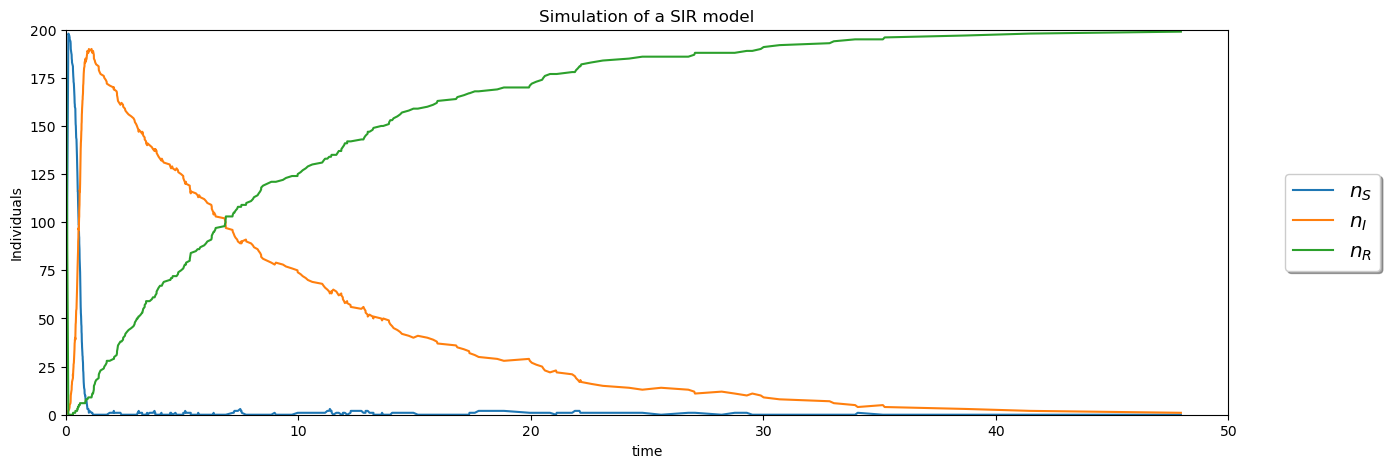

In [3]:
# Run the function and capture its output
time, nS, nI, nR = gillespie()

# Extract all the variables
extracted_time = time
extracted_nS = nS
extracted_nI = nI
extracted_nR = nR

Next we will derive write down an ODE system using the mass-action logic

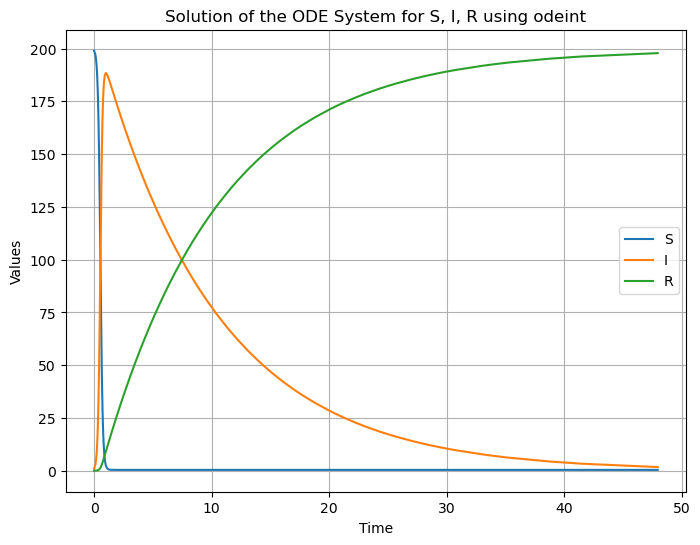

In [4]:
# Define the system of ODEs in terms of x, y, and t
def SIR_ODE(variables, t, a=0.05, b=0.02, c=0.1):
    S, I, R = variables
    dSdt = -a * S * I + b * I 
    dIdt = a * S * I - b * I - c * I  
    dRdt = c * I
    return [dSdt, dIdt, dRdt]

# Define the initial values for S, I, R
initial_values = [199, 1 , 0]  # Initial values for S, I, R

# Solve the ODE system using odeint
solution = odeint(SIR_ODE, initial_values, extracted_time)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(extracted_time, solution[:, 0], label='S')
plt.plot(extracted_time, solution[:, 1], label='I')
plt.plot(extracted_time, solution[:, 2], label='R')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Solution of the ODE System for S, I, R using odeint')
plt.legend()
plt.grid(True)
plt.show()


We use a minimise fuction to minimise the difference between the observed data (from Gillespie) and the solution to the ODE. This give us an estimate for the parameters a,b,c which makes the data more likely.

In [7]:
# Objective function to minimize (difference between model and observed data for all compartments)
def objective(params):
    a, b, c = params
    
    # Define the initial values for S, I, R
    initial_values = [199, 1, 0]  # Modify these based on your initial conditions
    
    # Solve the ODE system using provided parameters
    sol = odeint(SIR_ODE, initial_values, extracted_time, args=(a, b, c))
    
    # Your observed data obtained from Gillespie simulation (for S, I, R)
    observed_data = np.vstack((extracted_nS, extracted_nI, extracted_nR)).T
    
    # Calculate the difference between the model output and observed data for all compartments
    diff = (observed_data - sol).ravel()  # Flatten the arrays for all compartments
    return np.sum(diff**2)  # You can modify this depending on the specific method (e.g., least squares)

# Initial guess for the parameters (a, b, c)
initial_guess = [0.05, 0.05, 0.05]  

# Minimize the objective function to estimate parameters
result = minimize(objective, initial_guess, method='TNC')

# Extract the estimated parameters
estimated_params = result.x
print("Estimated Parameters:", estimated_params)

Estimated Parameters: [0.04895982 0.02921211 0.10900541]


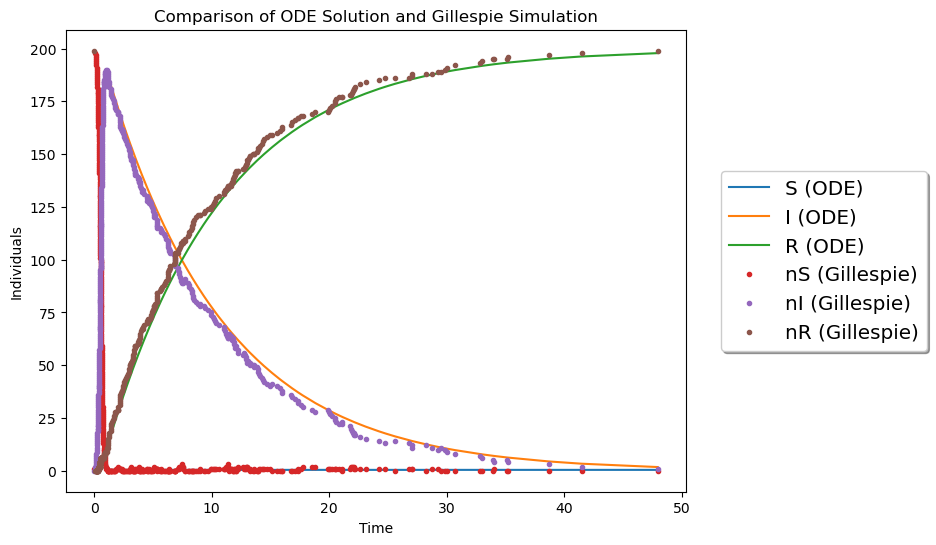

In [8]:
def plot_gillespie():
    plt.figure(figsize=(8, 6))
    
    # Plot solution from odeint
    plt.plot(extracted_time, solution[:, 0], label='S (ODE)')
    plt.plot(extracted_time, solution[:, 1], label='I (ODE)')
    plt.plot(extracted_time, solution[:, 2], label='R (ODE)')
    
    # Plot extracted data from gillespie
    plt.plot(extracted_time, extracted_nS, 'o', label='nS (Gillespie)', markersize=3)
    plt.plot(extracted_time, extracted_nI, 'o', label='nI (Gillespie)', markersize=3)
    plt.plot(extracted_time, extracted_nR, 'o', label='nR (Gillespie)', markersize=3)
    
    legend = plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', shadow=True, fontsize='x-large')
    
    plt.title('Comparison of ODE Solution and Gillespie Simulation')
    plt.xlabel('Time')
    plt.ylabel('Individuals')

    plt.show()

# Call the new function to generate the plot
plot_gillespie()


By running a few times, we should see the parameters match closely to the expected parameter value and the graph should show the ODE and gillespie algorithm give similar results, however there is a slight error. For example, parameter b should be 0.02 but sometimes it is negative for example.